# BASELINE

## DATA CLEANING

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from tqdm.notebook import tqdm

from IPython.display import clear_output
from pymorphy2 import MorphAnalyzer

In [42]:
train_df = pd.read_csv('data/vacancies_train.csv')
test_df = pd.read_csv('data/vacancies_test.csv')

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16629 entries, 0 to 16628
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         16629 non-null  object 
 1   experience   16629 non-null  object 
 2   schedule     16629 non-null  object 
 3   employment   16629 non-null  object 
 4   description  16629 non-null  object 
 5   key_skills   16629 non-null  object 
 6   salary       16629 non-null  float64
dtypes: float64(1), object(6)
memory usage: 909.5+ KB


In [44]:
train_df.head()

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0


In [45]:
train_df.duplicated().sum()

308

# TODO: EDA

In [46]:
X_train, y_train = train_df['description'], train_df['salary']

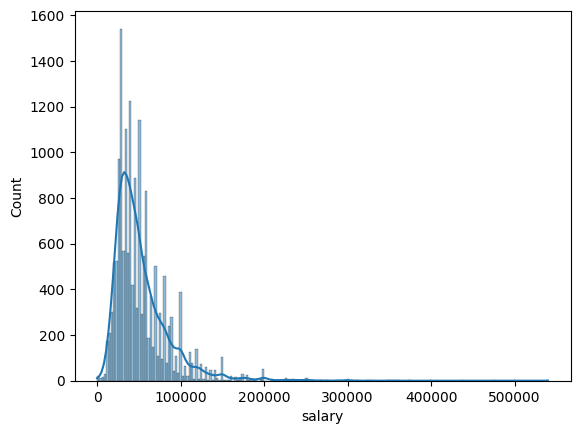

In [47]:
ax = sns.histplot(y_train, kde=True)

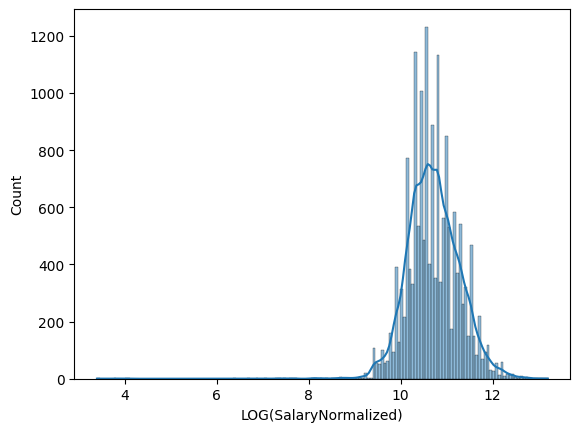

In [48]:
ax = sns.histplot(np.log(y_train), kde=True)
ax.set_xlabel("LOG(SalaryNormalized)")
None

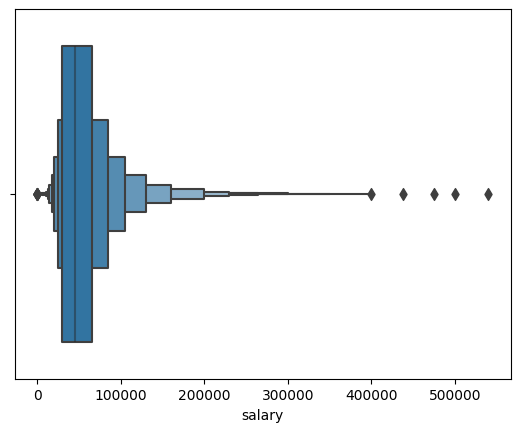

In [49]:
ax = sns.boxenplot(y_train, x=y_train)

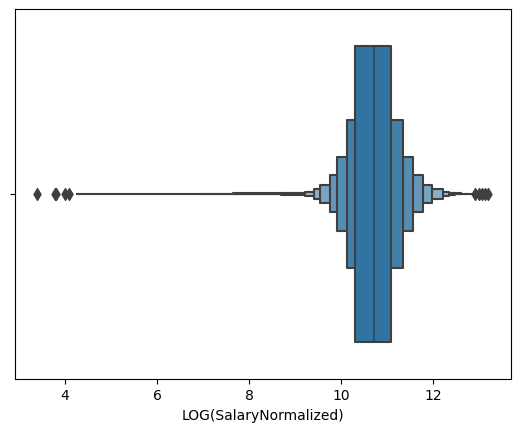

In [50]:
ax = sns.boxenplot(y_train, x=np.log(y_train))
ax.set_xlabel("LOG(SalaryNormalized)")
None

#### X_train

In [51]:
sw = stopwords.words('russian')
morph = MorphAnalyzer()

def preprocess_text(text):
    text = text.lower()
    #print(1, text)
    text = re.sub(r"([.,!?])", r" \1 ", text) # giving all punctuation signs a space 
    #print(2, text)
    text = re.sub(r"[^а-яёА-ЯЁ+#]+", r" ", text) # deleteng all elements that are not letters or signs
    #print(3, text)
    text = " ".join([morph.normal_forms(token)[0] for token in text.split(" ") if (token not in sw)])
    #print(4, text)
    return text

In [52]:
bar = tqdm(total=X_train.shape[0])
X_train_preprocessed = []
for i in range(X_train.shape[0]):
    X_train_preprocessed.append(preprocess_text(X_train.iloc[i]))
    bar.update()
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)

  0%|          | 0/16629 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
X_train_preprocessed.columns = ["text"]
y_train.index = range(y_train.shape[0])
X_train_preprocessed['target'] = y_train
X_train_preprocessed

In [ ]:
X_train.iloc[0]

In [ ]:
preprocess_text(X_train.iloc[0])

In [ ]:
X_train_preprocessed.to_csv("data/preprocessed_data_train.csv", index=False)

#### X_test

In [ ]:
test_df

In [ ]:
X_test = test_df['description']

In [ ]:
X_test

In [ ]:
bar = tqdm(total=X_test.shape[0])
X_test_preprocessed = []
for i in range(X_test.shape[0]):
    X_test_preprocessed.append(preprocess_text(X_test.iloc[i]))
    bar.update()
X_test_preprocessed = pd.DataFrame(X_test_preprocessed)

In [ ]:
X_test_preprocessed

In [ ]:
X_test_preprocessed.columns = ["text"]
ids = test_df.id
X_test_preprocessed['id'] = ids

In [ ]:
X_test_preprocessed

In [ ]:
X_test_preprocessed.to_csv("data/preprocessed_data_test.csv", index=False)

# MODELS

In [2]:
# BAZA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from argparse import Namespace
from collections import Counter
import string
import os
# OSNOVA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from torchmetrics.functional import r2_score

In [3]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):
        self._token_to_idx = dict()
        if token_to_idx is not None:
            self._token_to_idx = token_to_idx
        self._idx_to_token = {
            index: token
            for token, index in self._token_to_idx
        }
    
    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        if token in self._token_to_idx:
            return self._token_to_idx[token]
        raise KeyError(f"Token {token} is not in Vocabulary")
   
    def lookup_index(self, index):
        if index in self._idx_to_token:
            return self._idx_to_token[index]
        raise KeyError(f"No token with index {index} in Vocabulary")        
        
    def __len__(self):
        return len(self._token_to_idx)

In [4]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, 
                 mask_token="<MSK>", unk_token="<UNK>",
                 begin_token="<BGN>", end_token="<END>"
                ):
        super(SequenceVocabulary, self).__init__(token_to_idx)
        
        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_token = begin_token
        self._end_token = end_token
        
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_index = self.add_token(self._begin_token)
        self.end_index = self.add_token(self._end_token)
    
    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [5]:
class Vectorizer(object):
    def __init__(self, vocab=None):
        self.vocab = vocab
        
    @classmethod
    def from_dataframe(cls, df, cutoff=10):
        vocab = SequenceVocabulary()
        
        tokens_counter = Counter()
        for text in df.text:
            for token in text.split(" "):
                tokens_counter[token] += 1
                
        for token, count in tokens_counter.items():
            if count >= cutoff:
                vocab.add_token(token)
        
        return cls(vocab)
    
    def vectorize(self, description, vector_length=-1):
        # tokens
        indices = [self.vocab.begin_index]
        for token in description.split(" "):
            indices.append(self.vocab.lookup_token(token))
        indices.append(self.vocab.end_index)
        # filling
        if vector_length < 0:
            vector_length = len(indices)
        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.vocab.mask_index
        return out_vector

In [6]:
class JobsDataset(Dataset):
    def __init__(self, data, vectorizer):
        self.data = data
        self._vectorizer = vectorizer
        
        get_length = lambda text: len(text.split(" "))
        
        self._max_length = max(self.data.text.apply(get_length)) + 2 
    
    def __getitem__(self, index):
        x_data = self._vectorizer.vectorize(self.data.text.iloc[index], self._max_length)
        y_target = self.data.target.iloc[index]
        return {
            'x_data': x_data,
            'y_target': y_target
        }
    
    def __len__(self):
        return len(self.data)
    
    def get_num_batches(self, batch_size):
        return len(self) // batch_size
    
    @classmethod
    def load_dataset_and_make_vectorizer(cls, df_path):
        df = pd.read_csv(df_path)
        vectorizer = Vectorizer.from_dataframe(df)
        return cls(df, vectorizer)

In [30]:
def seed_everywhere(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [31]:
def generate_batches(dataset, batch_size, shuffle=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    for data_dict in dataloader:
        out_dict = dict()
        for name, data in data_dict.items():
            out_dict[name] = data_dict[name].to(device)
        yield out_dict

In [82]:
args = Namespace(
    #dirs
    train_data_path = 'data/preprocessed_data_train.csv',
    test_data_path = 'data/preprocessed_data_test.csv',
    model_filepath='data/model_storage/model.pth',
    #model hyper params
    seed = 1,
    dropout_p = 0.2,
    embedding_size = 100,
    hidden_size = 200,
    batch_size = 128,
    num_epochs = 100,
    learning_rate=0.001,
    early_stopping_criteria=5,
    #utils
    use_cuda = True,
)

train_state = {
    'stop_early': False,
    'early_stopping_step': 0,
    'early_stopping_best_val': 1e8,
    'learning_rate': args.learning_rate,
    'epoch_index': 0,
    'train_loss': [],
    'val_loss': [],
    'test_loss': -1,
    'model_filename': args.model_filepath,
    'train_r2':[],
    'val_r2':[],
}

def update_train_state(args, model, train_state):
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        print(f"Saving model on {train_state['epoch_index']} epoch")
        train_state['stop_early'] = False
    elif train_state['epoch_index'] >= 1:
        loss_t2, loss_t = train_state['train_loss'][-2:]
        
        if abs(loss_t - loss_t2) >= train_state['early_stopping_best_val']:
            train_state['early_stopping_step'] += 1
        else:
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                print(f"Saving model on {train_state['epoch_index']} epoch")
            train_state['early_stopping_step'] = 0
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    return train_state

In [83]:
class SalaryPredictor(nn.Module):
    def __init__(self, embedding_size, num_embeddings, hidden_size, dropout_p, padding_idx):
        super(SalaryPredictor, self).__init__()
        
        self.emb = nn.Embedding(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_size,
            padding_idx=padding_idx,
        )
        self.convert = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=hidden_size),
            nn.ELU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ELU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ELU(),
        )
        self._dropout_p = dropout_p
        self.lin1 = nn.Linear(in_features=hidden_size, out_features=int(hidden_size / 2))
        self.lin2 = nn.Linear(in_features=int(hidden_size / 2), out_features=1)
    
    def forward(self, x_in):
        #print(x_in.dtype)
        #print(x_in.size())
        x_embedded = self.emb(x_in).sum(dim=1)
        #print(x_embedded.dtype)
        #print(x_embedded.size())
        x_out = self.convert(x_embedded)
        #print(x_out.dtype)
        #print(x_out.size())
        x_out = F.dropout(x_out, p=self._dropout_p)
        #print(x_out.dtype)
        #print(x_out.size())
        x_out = F.relu(F.dropout(self.lin1(x_out), p=self._dropout_p))
        #print(x_out.dtype)
        #print(x_out.size())
        x_out = self.lin2(x_out)
        #print(x_out.dtype)
        #print(x_out.size())
        
        return x_out.squeeze()

In [84]:
# cuda setting
if not torch.cuda.is_available():
    args.use_cuda = False
    
args.device = torch.device("cuda" if args.use_cuda else "cpu")
print(f"USE CUDA -> {args.use_cuda}")

USE CUDA -> False


In [85]:
#train test split
from sklearn.model_selection import train_test_split

In [86]:
df_train, df_val = train_test_split(pd.read_csv(args.train_data_path), shuffle=True, random_state=1)
df_train.to_csv(args.train_data_path)

In [87]:
# dataset and classifier preparing

train_dataset = JobsDataset.load_dataset_and_make_vectorizer(args.train_data_path)
vectorizer = train_dataset._vectorizer
val_dataset = JobsDataset(df_val, vectorizer)

test_dataset = JobsDataset(pd.read_csv(args.test_data_path), vectorizer)

model = SalaryPredictor(
    embedding_size=args.embedding_size, 
    num_embeddings=len(vectorizer.vocab),
    hidden_size=args.hidden_size,
    dropout_p=args.dropout_p,
    padding_idx=0
)

In [88]:
print(model)

SalaryPredictor(
  (emb): Embedding(4145, 100, padding_idx=0)
  (convert): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
  )
  (lin1): Linear(in_features=200, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=1, bias=True)
)


In [89]:
max_length = max(train_dataset._max_length, val_dataset._max_length, test_dataset._max_length)
train_dataset._max_length = max_length
val_dataset._max_length = max_length
test_dataset._max_length = max_length

training:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/41 [00:00<?, ?it/s]

split=val:   0%|          | 0/13 [00:00<?, ?it/s]

r2 -0.9033641692552485
loss 30942.26339285714
Saving model on 0 epoch


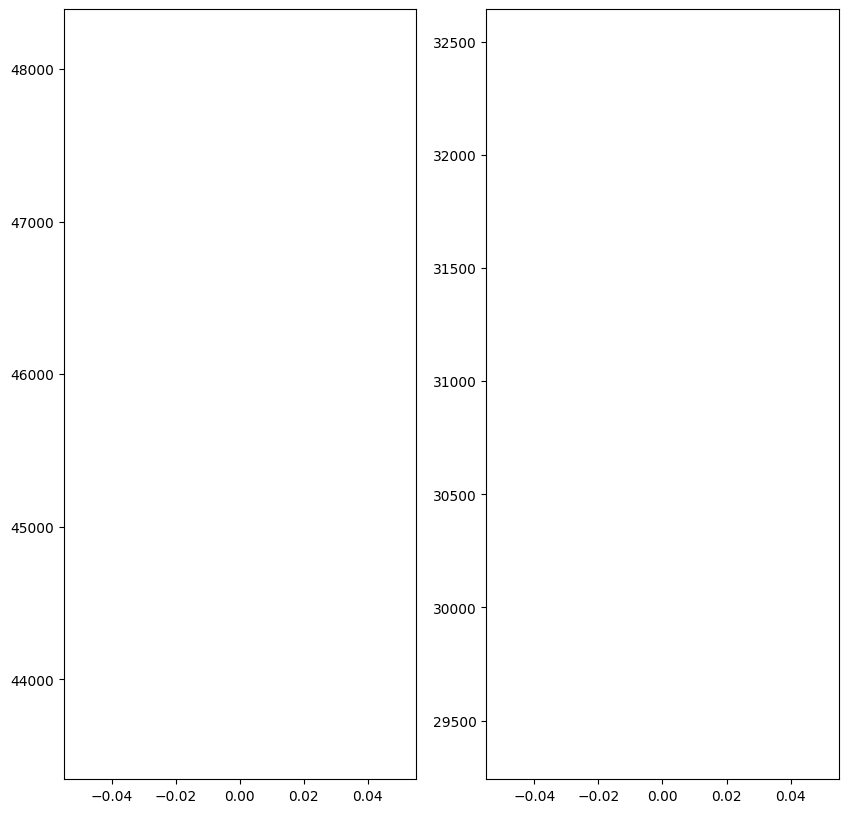

r2 -0.251908838422526
loss 24600.931501116072
Saving model on 1 epoch
r2 -0.06158768488561435
loss 22035.331891741072
Saving model on 2 epoch
r2 0.05727281158164232
loss 21040.1435546875
Saving model on 3 epoch
r2 0.1037068888203572
loss 20086.69405691964
Saving model on 4 epoch
r2 0.11015455623379326
loss 19512.68282645089
Saving model on 5 epoch
r2 0.17963134807695352
loss 18868.5205078125
Saving model on 6 epoch
KeyBoard Interrupt


In [90]:
model = model.to(args.device)
loss_func = nn.L1Loss()
optimizer = opt.Adam(model.parameters(), lr=args.learning_rate)
scheduler = opt.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

epoch_bar = tqdm(desc="training", total=args.num_epochs, position=0)
train_bar = tqdm(desc="split=train", total=train_dataset.get_num_batches(args.batch_size), position=1, leave=True)
val_bar = tqdm(desc="split=val", total=val_dataset.get_num_batches(args.batch_size), position=1, leave=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index
        
        batch_generator = generate_batches(dataset=train_dataset, batch_size=args.batch_size, device=args.device)
        running_loss = 0.0
        running_r2 = 0.0
        model.train()
        for batch_index, batch_dict in enumerate(batch_generator):
            model.zero_grad()
            
            y_pred = model(x_in=batch_dict['x_data'])
            
            
            loss = loss_func(y_pred, batch_dict['y_target'].to(torch.float32))
            loss_t = loss.item()
            running_loss += loss_t
            
            loss.backward()
            
            optimizer.step()
            
            r2_t = r2_score(y_pred, batch_dict['y_target']).item()
            running_r2 += r2_t
            
            
            train_bar.set_postfix(loss = running_loss, r2 = r2_t, epoch = epoch_index)
            train_bar.update()
          
        running_r2 = running_r2 / (train_dataset.get_num_batches(args.batch_size) + 1)
        running_loss /= (train_dataset.get_num_batches(args.batch_size) + 1)
        train_state['train_loss'].append(running_loss)
        train_state['train_r2'].append(running_r2)
        
        
        batch_generator = generate_batches(dataset=val_dataset, batch_size=args.batch_size, device=args.device)
        running_loss = 0.0
        running_r2 = 0.0
        model.eval()
        for batch_index, batch_dict in enumerate(batch_generator): 
            y_pred = model(x_in=batch_dict['x_data'])
            
            
            loss = loss_func(y_pred, batch_dict['y_target'].to(torch.float32))
            loss_t = loss.item()
            running_loss += loss_t
            
            
            r2_t = r2_score(y_pred, batch_dict['y_target']).item()
            running_r2 += r2_t
            
            
            val_bar.set_postfix(loss = running_loss, r2 = r2_t, epoch = epoch_index)
            val_bar.update()
          
        running_r2 = running_r2 / (val_dataset.get_num_batches(args.batch_size) + 1)
        running_loss /= (val_dataset.get_num_batches(args.batch_size) + 1)
        print("r2", running_r2)
        print("loss", running_loss)
        train_state['val_loss'].append(running_loss)
        train_state['val_r2'].append(running_r2)
        
        train_state = update_train_state(args, model, train_state)
        
        scheduler.step(train_state['val_loss'][-1])
        
        ax[0].clear()
        ax[1].clear()
        ax[0].plot(train_state['train_loss'])
        ax[1].plot(train_state['val_loss'])
        plt.show()
        #if train_state['stop_early']:
         ##   print('Stopped early')
         #   break
            
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("KeyBoard Interrupt")

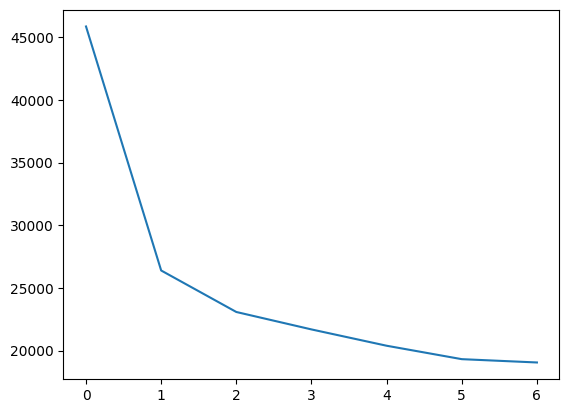

In [91]:
plt.plot(train_state['train_loss'])

In [17]:
from sklearn.metrics import r2_score as r2_score_sklearn

In [26]:
r2_score(y_pred, batch_dict['y_target']).item()

0.14326151686720667

In [27]:
r2_score_sklearn(batch_dict['y_target'].detach().numpy(), y_pred.detach().numpy())

0.14326151686720667

# Predict

In [ ]:
test_df = pd.read_csv(args.test_data_path)

In [ ]:
test_df

In [216]:
test_dict = test_df.to_dict()
ids = test_dict['id']
texts = test_dict['text']

In [233]:
model.eval()
result = {'id':[], 'salary':[]}
for index, text in texts.items():
    vectorized = torch.tensor(vectorizer.vectorize(text, train_dataset._max_length)).unsqueeze(dim=0)
    predicted = model(vectorized).item()
    result['id'].append(ids[index])
    result['salary'].append(predicted)
    
result = pd.DataFrame(result)

In [234]:
result

,id,salary
0,0,50756.835938
1,1,27514.220703
2,2,28001.964844
3,3,65158.046875
4,4,40583.125000
...,...,...
5538,5538,22708.271484
5539,5539,49500.570312
5540,5540,46605.476562
5541,5541,25058.099609


In [235]:
result.to_csv("data/results/test/test.csv", index=False)